<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Comparing--Deep-Learning-APIs-for-Image-Multi-Label-Classification" data-toc-modified-id="Comparing--Deep-Learning-APIs-for-Image-Multi-Label-Classification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Comparing  Deep Learning APIs for Image Multi-Label Classification</a></span><ul class="toc-item"><li><span><a href="#Inception-V3" data-toc-modified-id="Inception-V3-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Inception V3</a></span></li><li><span><a href="#OpenAI-Clip" data-toc-modified-id="OpenAI-Clip-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>OpenAI Clip</a></span></li></ul></li><li><span><a href="#Labeling-the-data" data-toc-modified-id="Labeling-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Labeling the data</a></span></li><li><span><a href="#Neo4j" data-toc-modified-id="Neo4j-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Neo4j</a></span></li><li><span><a href="#Find-similar-images" data-toc-modified-id="Find-similar-images-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Find similar images</a></span><ul class="toc-item"><li><span><a href="#Inception" data-toc-modified-id="Inception-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Inception</a></span></li><li><span><a href="#Clip" data-toc-modified-id="Clip-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Clip</a></span></li><li><span><a href="#Neo4j" data-toc-modified-id="Neo4j-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Neo4j</a></span></li></ul></li></ul></div>

# Computer Vision - Image Similarity Problem

In [1]:
# Models
from models.inception_v3 import Inception_V3
from models.openai_clip import OpenAI_clip

# Libraries
import numpy as np
import pandas as pd
import os
from IPython.display import Image as Image_display
from IPython.display import display

##  Comparing  Deep Learning APIs for Image Multi-Label Classification

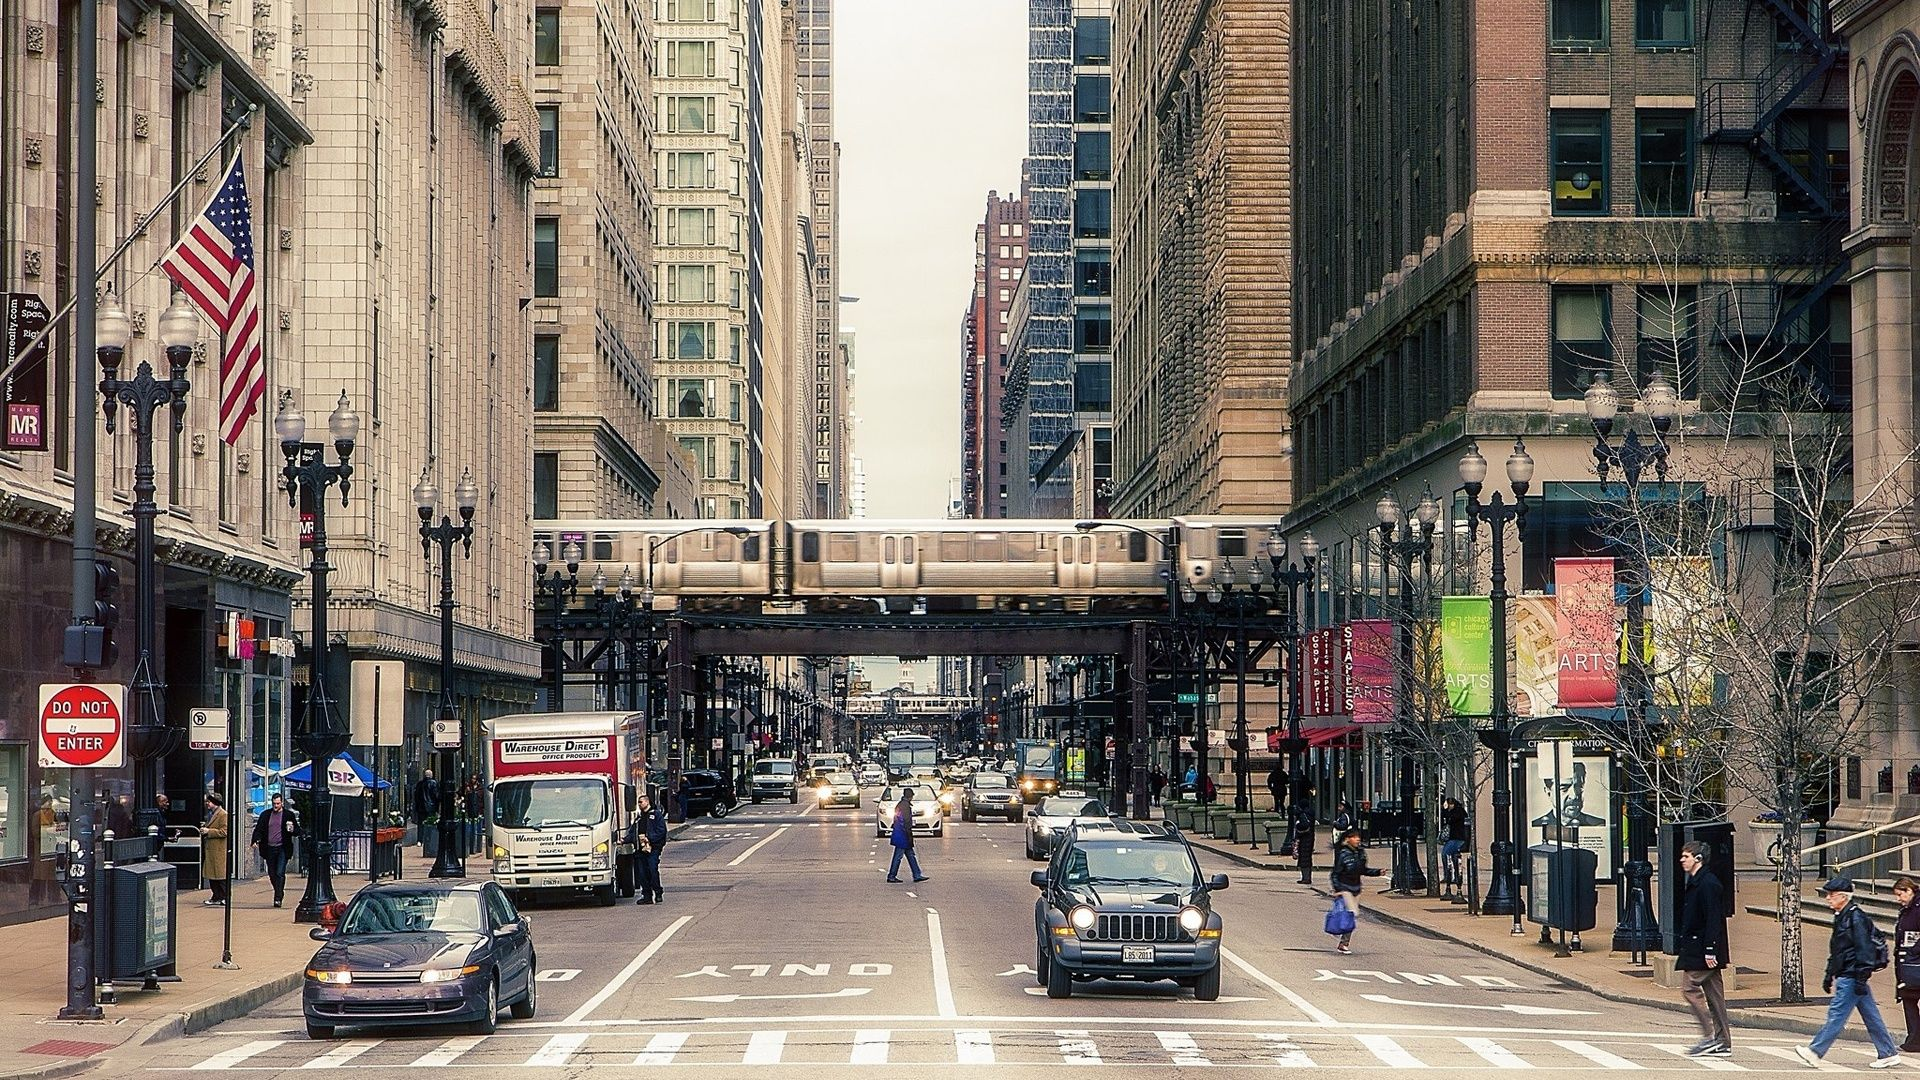

In [2]:
# Pick sample image
image_path = os.path.join("images","007.jpg")
display(Image_display(image_path))

### Inception V3

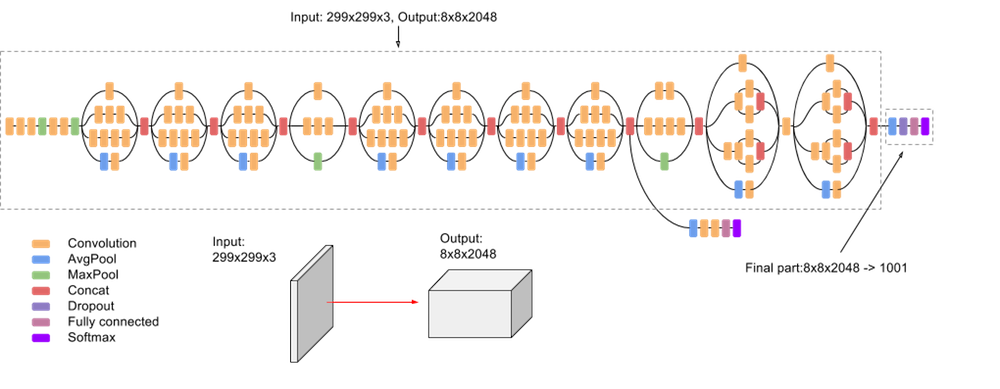

In [3]:
# OpenAI Diagram
display(Image_display(os.path.join("images","INCEPTION.png")))

In [4]:
# Define model
inception_model = Inception_V3()

In [5]:
# Predicted labels
inception_model.predict_classes(image_path, print_results=False)

{'Bell Cote',
 'Cab',
 'Cinema',
 'Forklift',
 'Garbage Truck',
 'Grocery Store',
 'Jinrikisha',
 'Minibus',
 'Streetcar',
 'Trolleybus'}

### OpenAI Clip

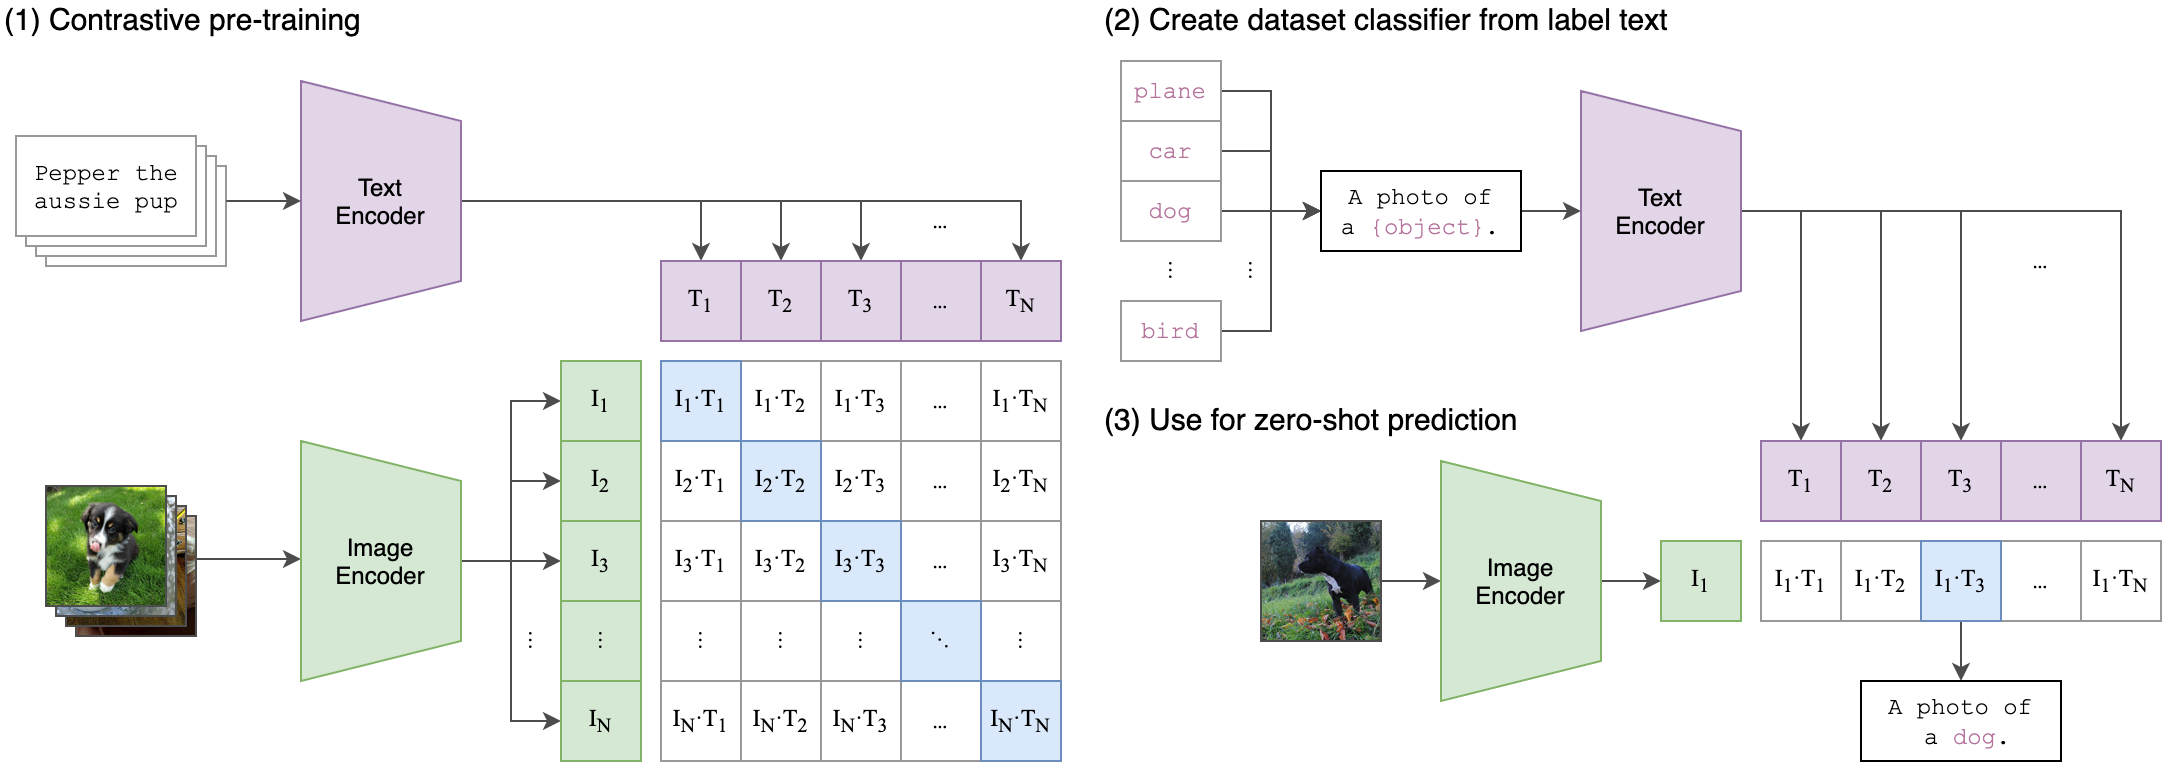

In [6]:
# OpenAI Diagram
display(Image_display(os.path.join("images","CLIP.png")))

In [7]:
# Define model
clip_model = OpenAI_clip()

Current Device reset


In [8]:
# Predicted labels
clip_model.predict_classes(image_path, print_results=False)

{'Balance Beam',
 'Cab',
 'Convertible',
 'Horizontal Bar',
 'Parallel Bars',
 'Pole',
 'School Bus',
 'Steel Arch Bridge',
 'Street Sign',
 'Streetcar',
 'Traffic Light',
 'Triumphal Arch',
 'Trolleybus',
 'Turnstile',
 'Viaduct'}

## Labeling the data

In [9]:
# Image paths
image_paths = [os.path.join("images", f) for f in os.listdir("images") if f.split(".")[-1]=="jpg"]

# Image labels
image_labels = {}
for img in image_paths:
    image_labels[img] = clip_model.predict_classes(img, top=15, print_results=False)

## Neo4j

In [10]:
import json
from neo4j import GraphDatabase, basic_auth

In [11]:
# Can be taken from above!
with open('image_labels.json') as f:
    labels_dicc = json.load(f)

In [12]:
# Get Driver
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "Passw0rd"))
session = driver.session()

# Delete all
delete_all = True
if delete_all:
    query = "MATCH (a)-[r]-(b) DELETE r"
    session.run(query)
    query = "MATCH (n) DELETE n"
    session.run(query)

In [13]:
# Get nodes
urls = list(labels_dicc.keys())
labels = list(labels_dicc.values())

nodes = []
for i in range(len(urls)):
    nodes.append({"name":urls[i].split("\\")[1], "url":urls[i]})

query = "UNWIND $nodes as data CREATE (n:Image) SET n = data;"

session.run(query, nodes=nodes)

In [14]:
# Create Labels
all_labels = set()
for lab in labels:
    all_labels.update(lab)
    
for l in sorted(all_labels):
    query = 'CREATE (n:Object {name: "' + l + '"})'
    session.run(query)

In [15]:
# Create Relations
for idx, url in enumerate(urls):
    for lab in labels[idx]:
        query = 'MATCH (n:Image {url:"'+ url +'"}),(l:Object {name: "' + lab + '"}) MERGE (n)-[c:Contains]->(l)'
        session.run(query)

In [16]:
# Close session
driver.close()

## Find similar images

### Inception

In [17]:
# Find Similar images with Inception
#model = Inception_V3()
#model.find_similar_images_dl("test_image.jpg")

### Clip

In [18]:
# Auxiliary Functions
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1) + len(set2) - intersection
    return float(intersection) / union

def similar_image_clip(image, top_k=3):
    scores = []
    for img in image_paths:
        if img != image:
            scores.append(jaccard_similarity(image_labels[image], image_labels[img]))
        else:
            scores.append(0)
    
    index_scores = [(idx,a) for idx,a in enumerate(scores)]
    index_scores.sort(key=lambda x: x[1], reverse = True)
    
    print("New image")
    display(Image_display(image))
    
    for i in range(top_k):
        print("Score {:.2f}".format(index_scores[i][1]))
        best_score = image_paths[index_scores[i][0]]
        display(Image_display(best_score))

New image


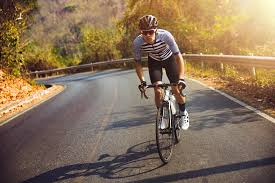

Score 0.65


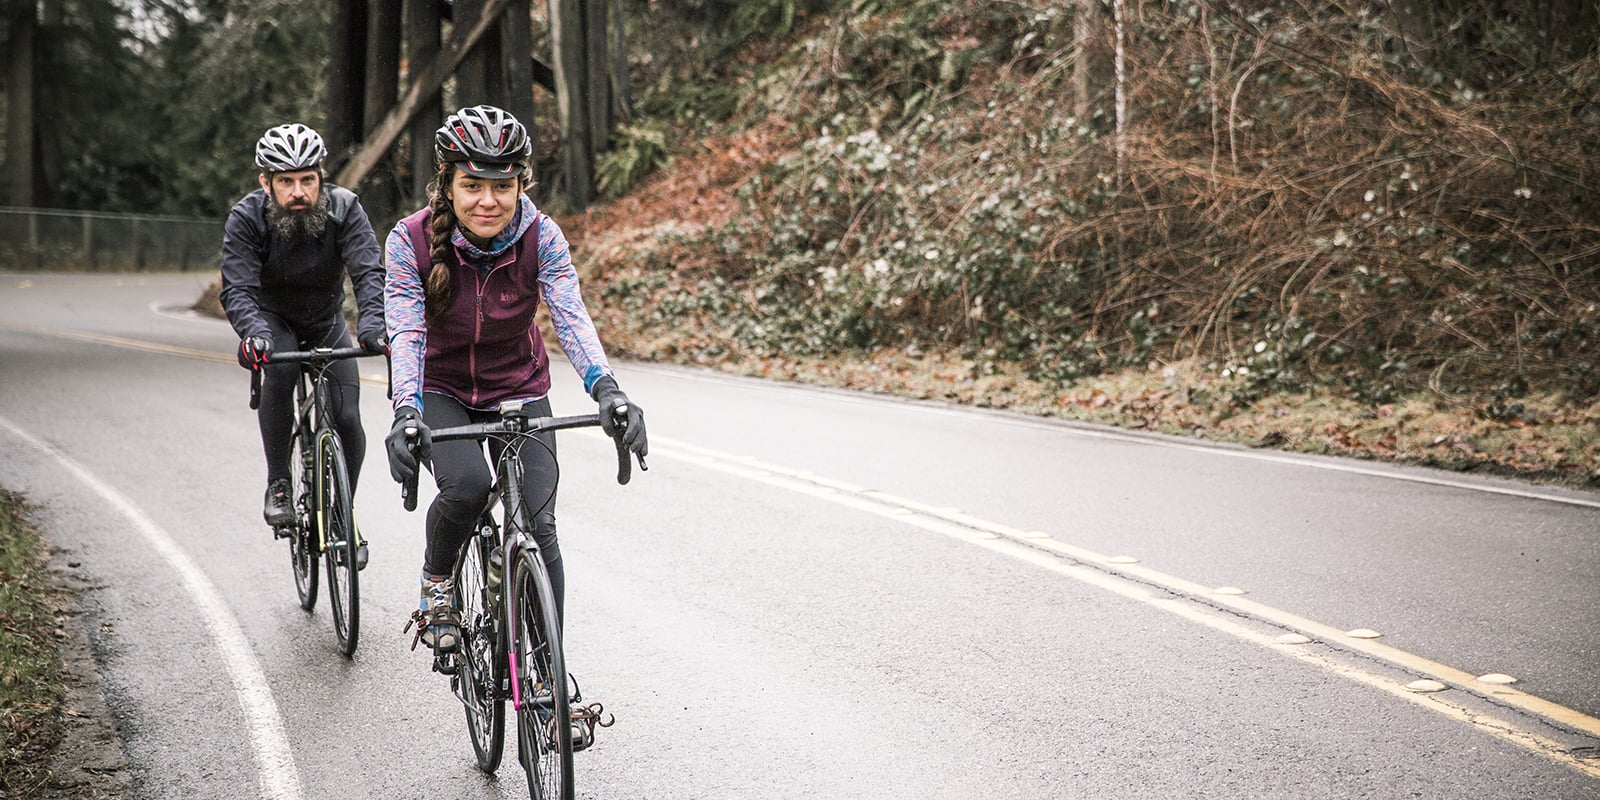

Score 0.47


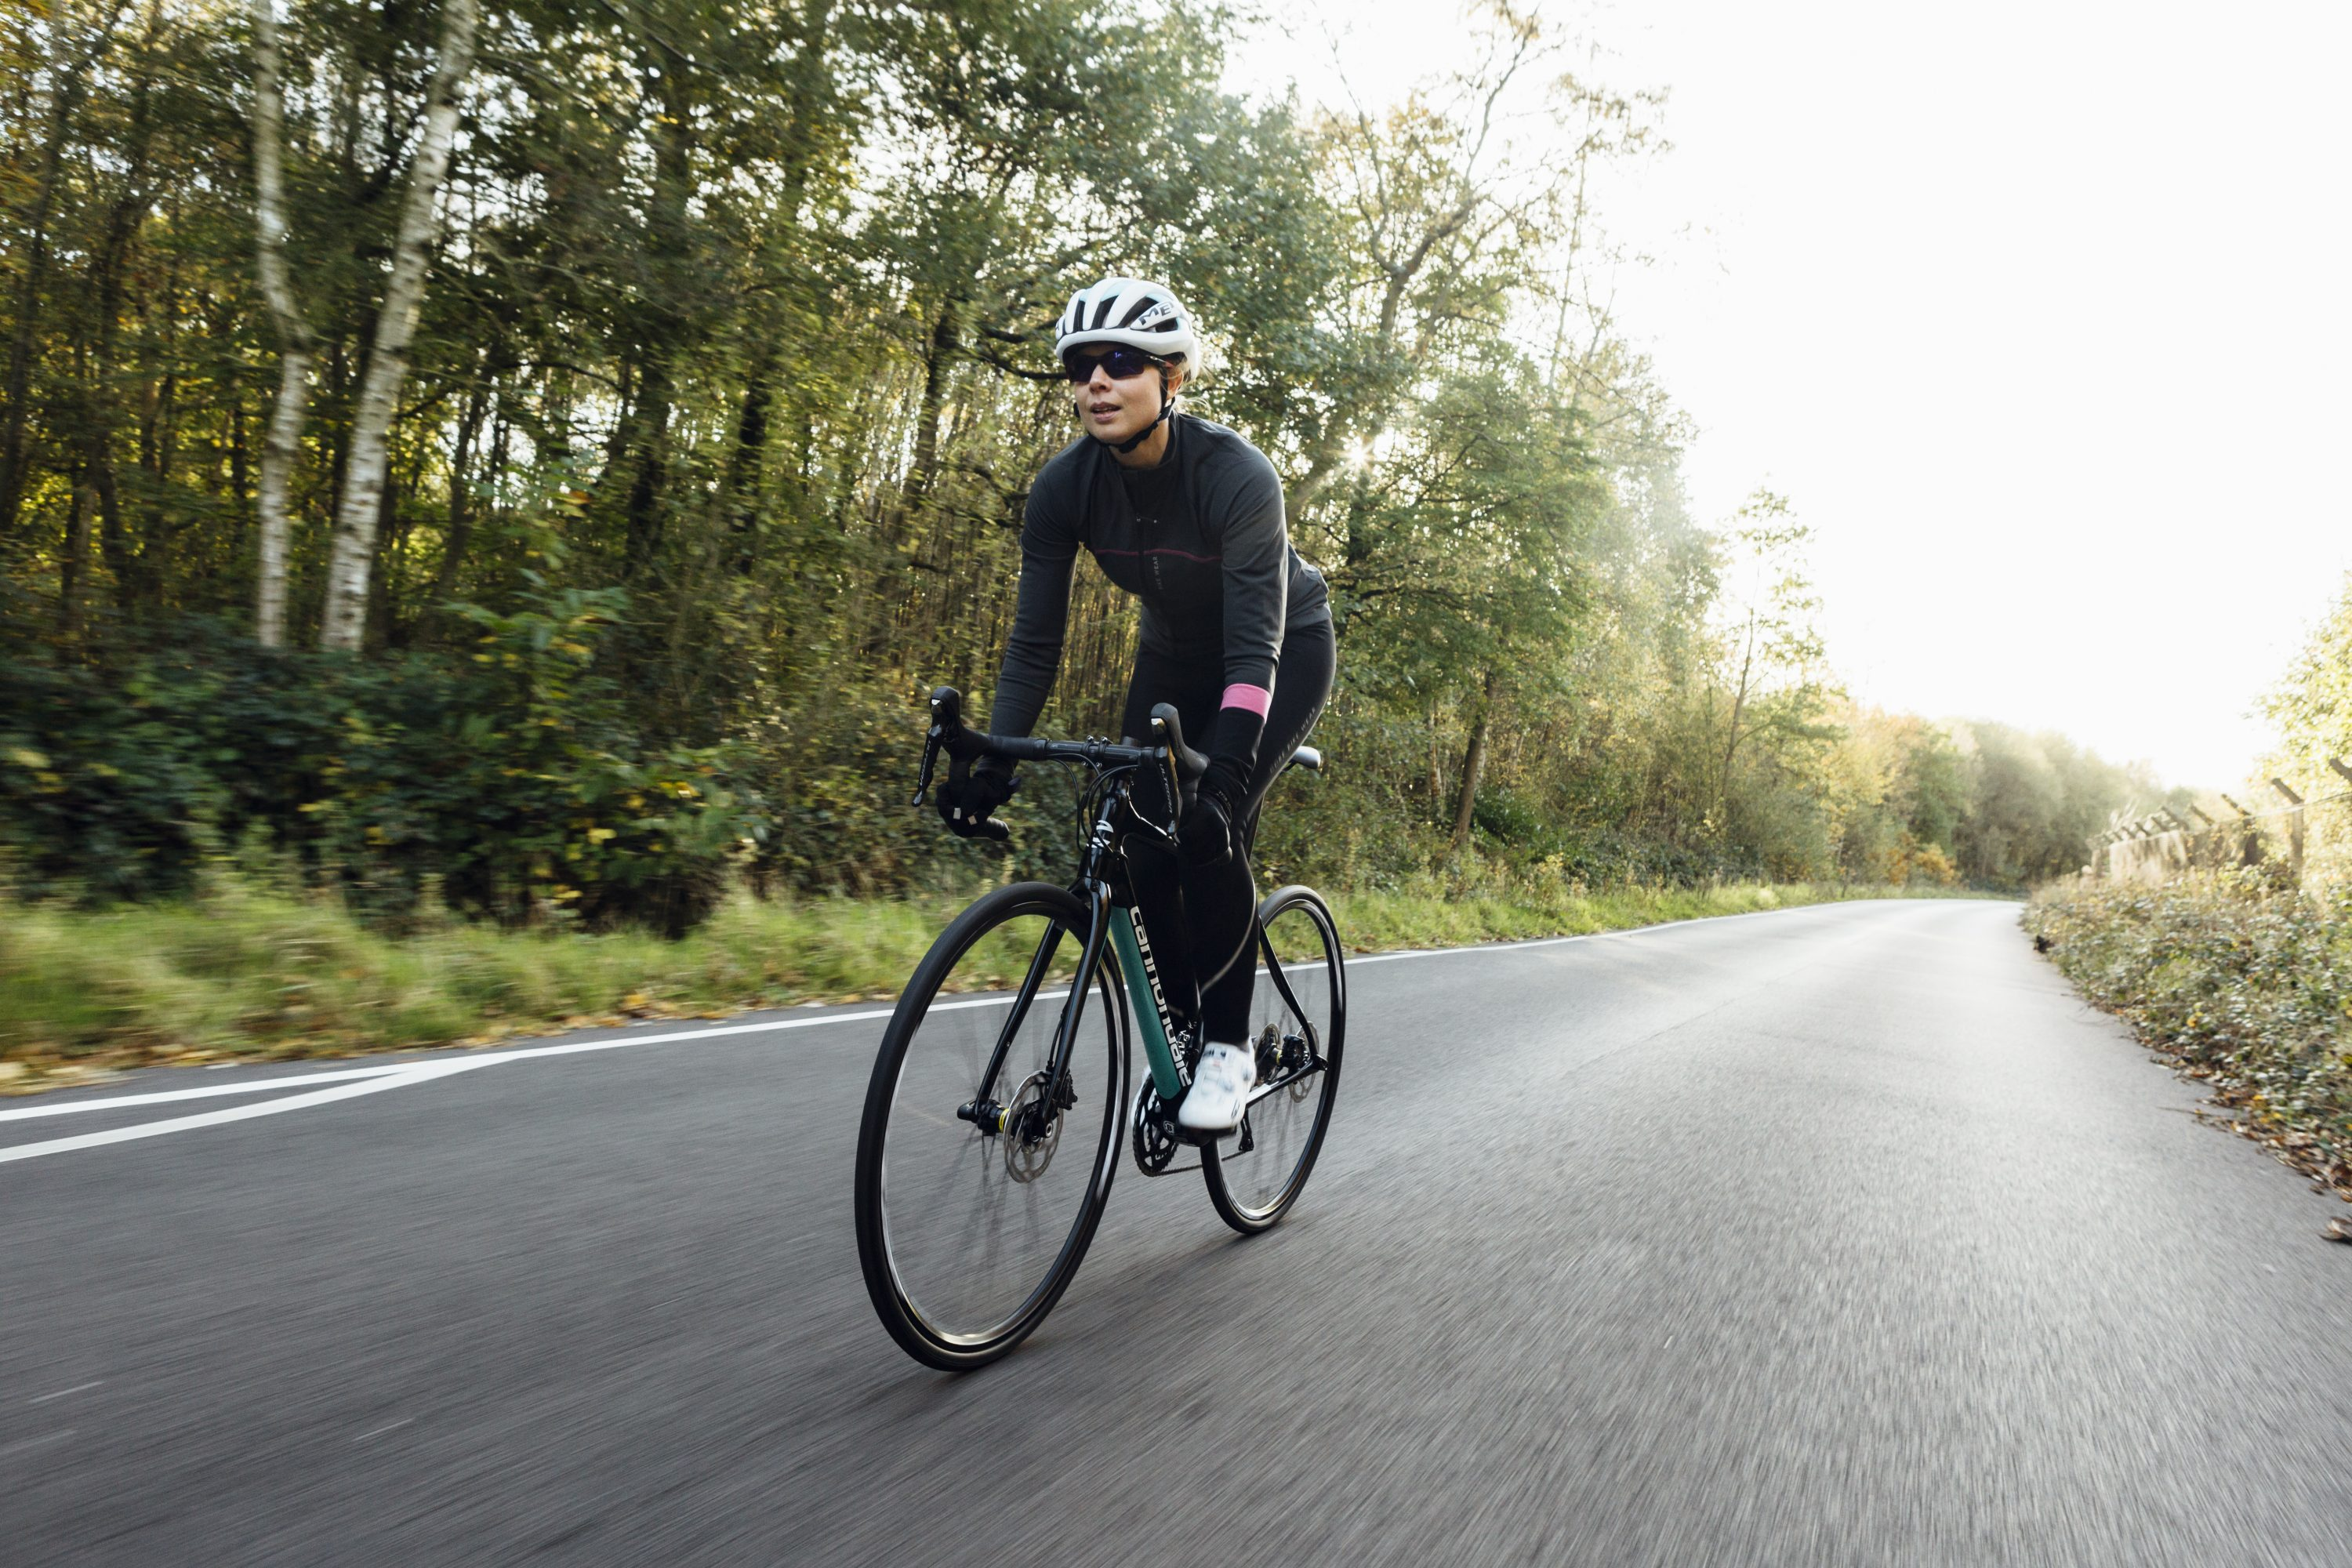

Score 0.32


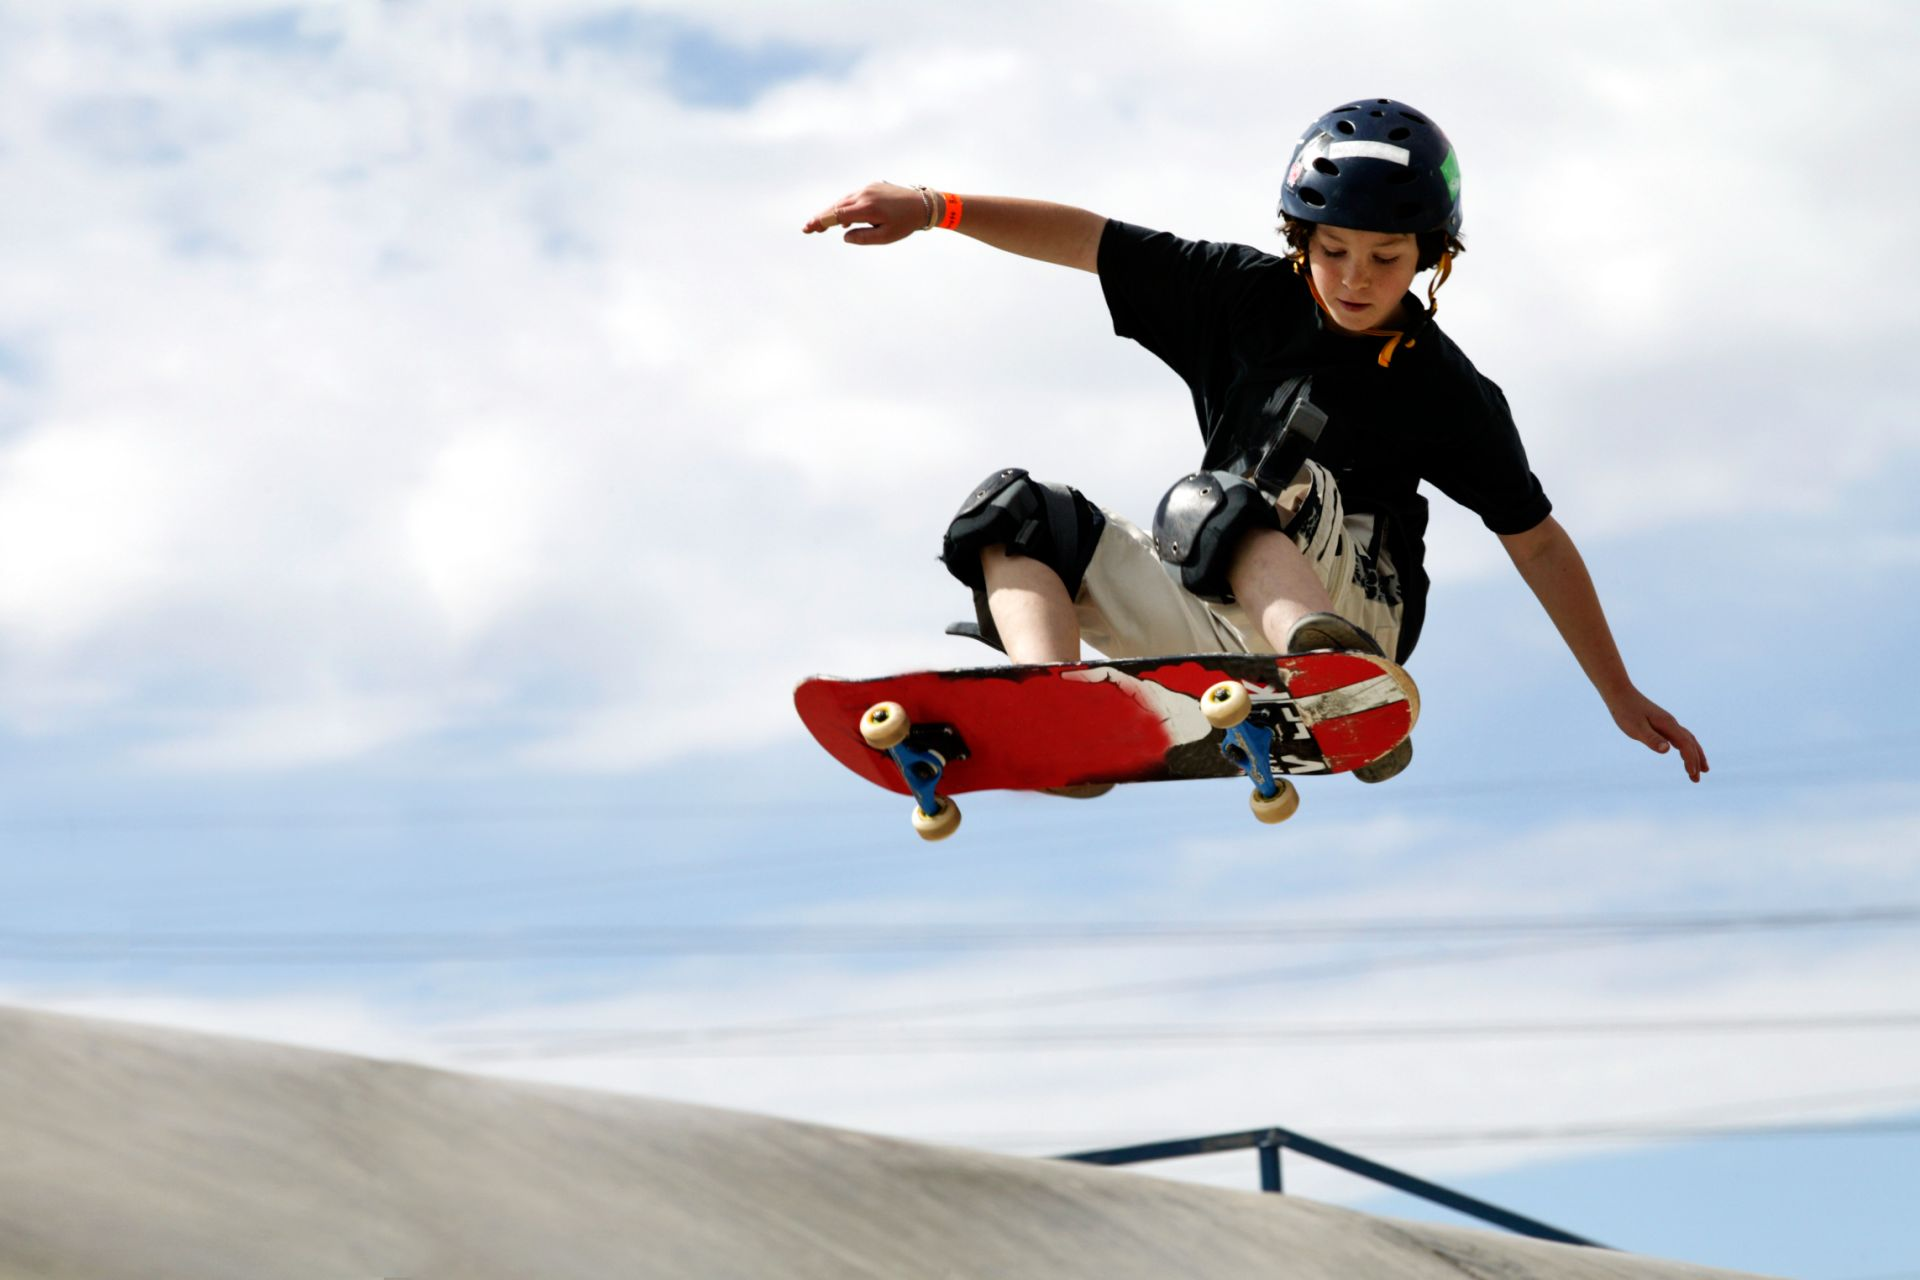

In [19]:
for _ in range(100):
    similar_image_clip(os.path.join("images","test_image.jpg"))
    break

### Neo4j

In [20]:
# Jaccard Function
def jaccard_similarity_query(image1_name, image2_name):
    
    query = """
             MATCH (p1:Image {name: '""" + image1_name + """'})-[:Contains]->(objects1)
             WITH p1, collect(id(objects1)) AS p1Objects
             MATCH (p2:Image {name: '""" + image2_name + """'})-[:Contains]->(objects2)
             WITH p1, p1Objects, p2, collect(id(objects2)) AS p2Objects
             RETURN p1.name AS from,
             p2.name AS to,
             gds.alpha.similarity.jaccard(p1Objects, p2Objects) AS similarity
           """
    
    return query

In [21]:
# Similar Images
def find_similar_images_neo4j(image1_name, top_k=3):
    
    # Get Driver
    driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "Passw0rd"))
    session = driver.session()

    df = pd.DataFrame()
    
    # Get all images
    query = "MATCH (n:Image) RETURN n.name"
    all_images = [item for sublist in session.run(query).values() for item in sublist]

    for image2_name in all_images:
        if image1_name != image2_name:
            query = jaccard_similarity_query(image1_name, image2_name)
            dtf_data = pd.DataFrame([dict(_) for _ in session.run(query)])
            df = pd.concat([df,dtf_data])
    
    similar_images_df = df.sort_values(by="similarity", ascending=False).reset_index(drop=True).head(top_k)



    query = "MATCH (n:Image {name:'" + image1_name + "'}) RETURN n.url"
    url = session.run(query).values()[0][0]

    print("New Image:")
    display(Image_display(url))

    print("Similar Images")

    for row in similar_images_df.iterrows():

        print("Jaccard Score: {:.2f}".format(row[1]["similarity"]))

        name = row[1]["to"]
        query = "MATCH (n:Image {name:'" + name + "'}) RETURN n.url"
        url = session.run(query).values()[0][0]
        display(Image_display(url))
        
    # Close driver
    driver.close()

In [22]:
# Get Driver
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "Passw0rd"))
session = driver.session()

In [23]:
# Add image to Neo4j
url = os.path.join('images', 'test_image.jpg')
name = "test_image.jpg"

new_nodes = [{'name': name, 'url': url}]
query = "UNWIND $new_nodes as data CREATE (n:Image) SET n = data;"
session.run(query, new_nodes = new_nodes)

# Create Relations
new_labels = clip_model.predict_classes(url, print_results=False)

for lab in new_labels:
    query = 'MATCH (n:Image {name:"' + name + '"}),(l:Object {name: "' + lab + '"}) MERGE (n)-[c:Contains]->(l)'
    session.run(query)

In [35]:
clip_model.predict_classes(os.path.join('images', '002.jpg'), print_results=False, top=15)

{'Admiral',
 'Box Turtle',
 'Drake',
 'Leatherback Turtle',
 'Loggerhead',
 'Lycaenid',
 'Maillot',
 'Mud Turtle',
 'Pembroke',
 'Puffer',
 'Scuba Diver',
 'Snorkel',
 'Swimming Trunks',
 'Terrapin'}

New Image:


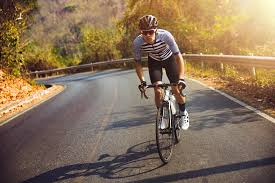

Similar Images
Jaccard Score: 0.73


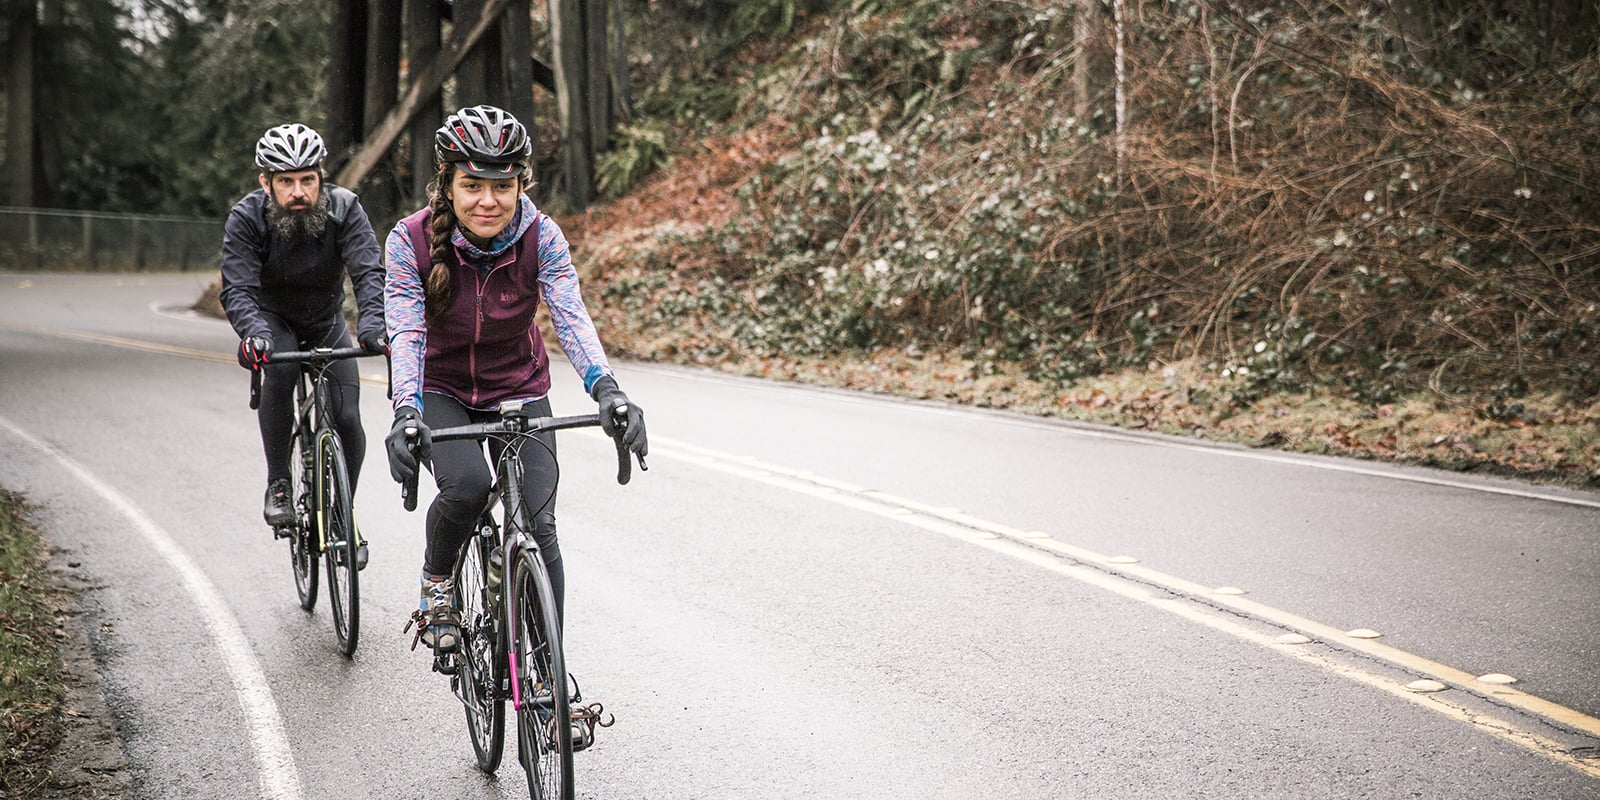

Jaccard Score: 0.53


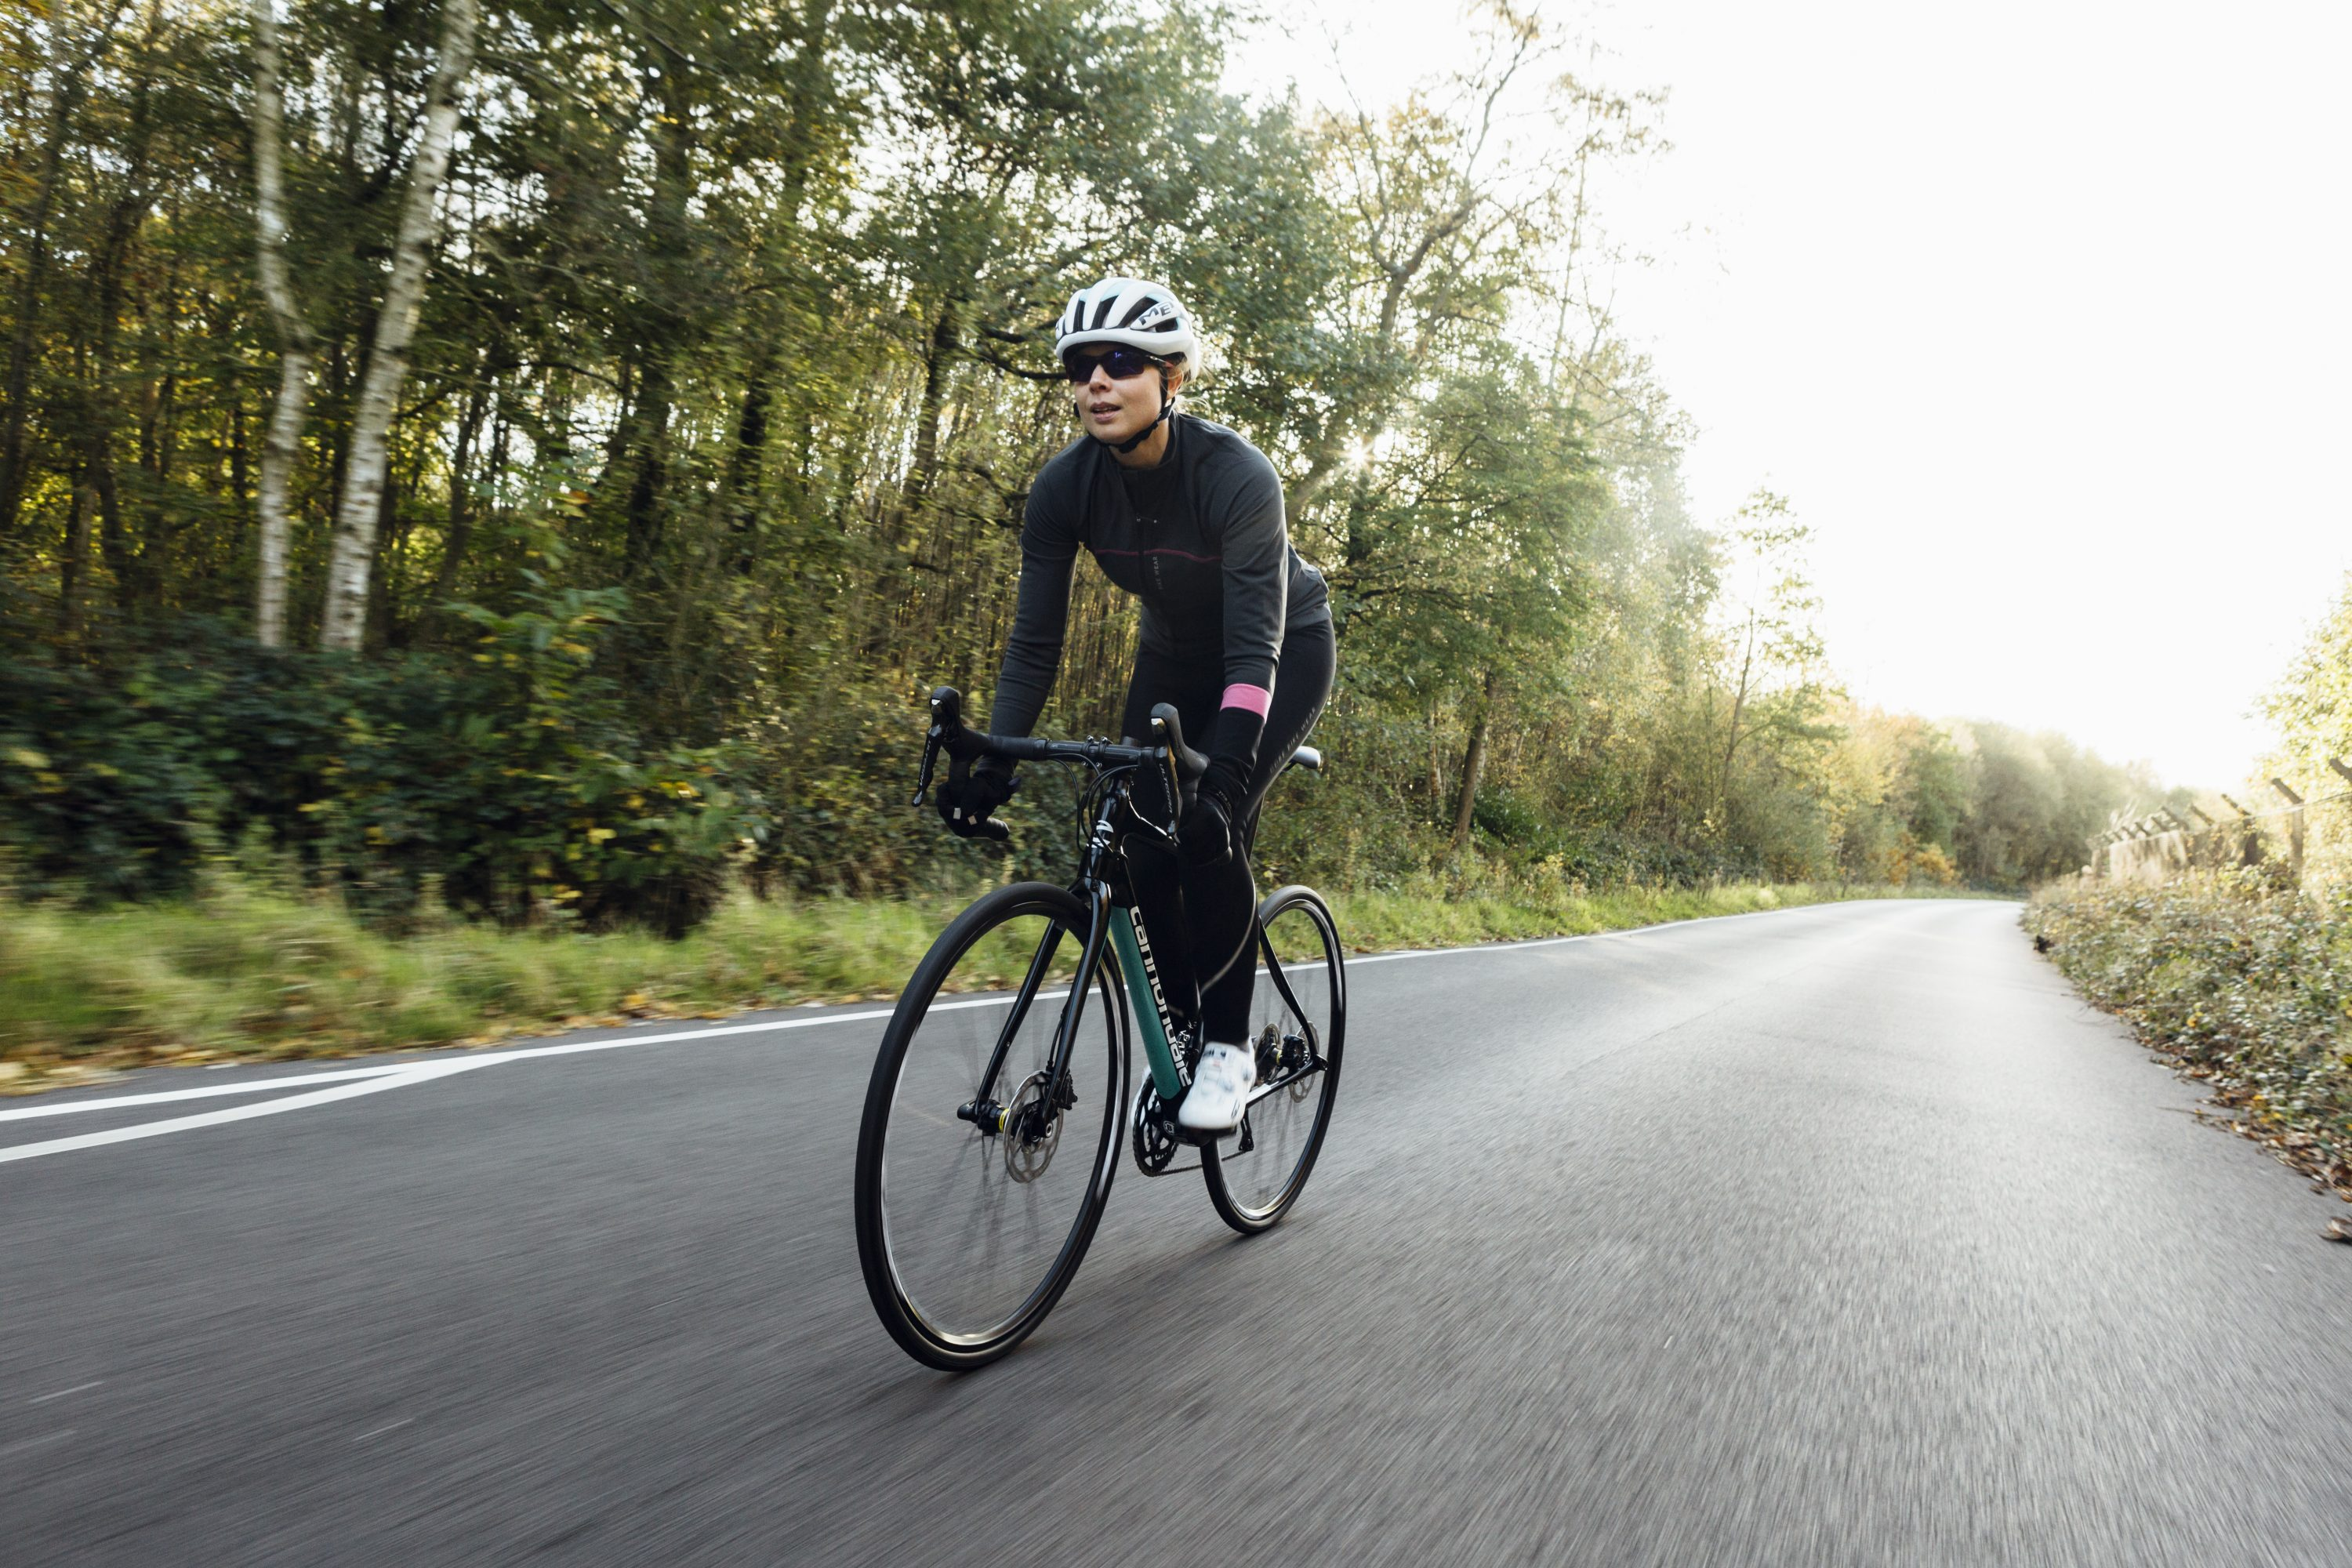

Jaccard Score: 0.35


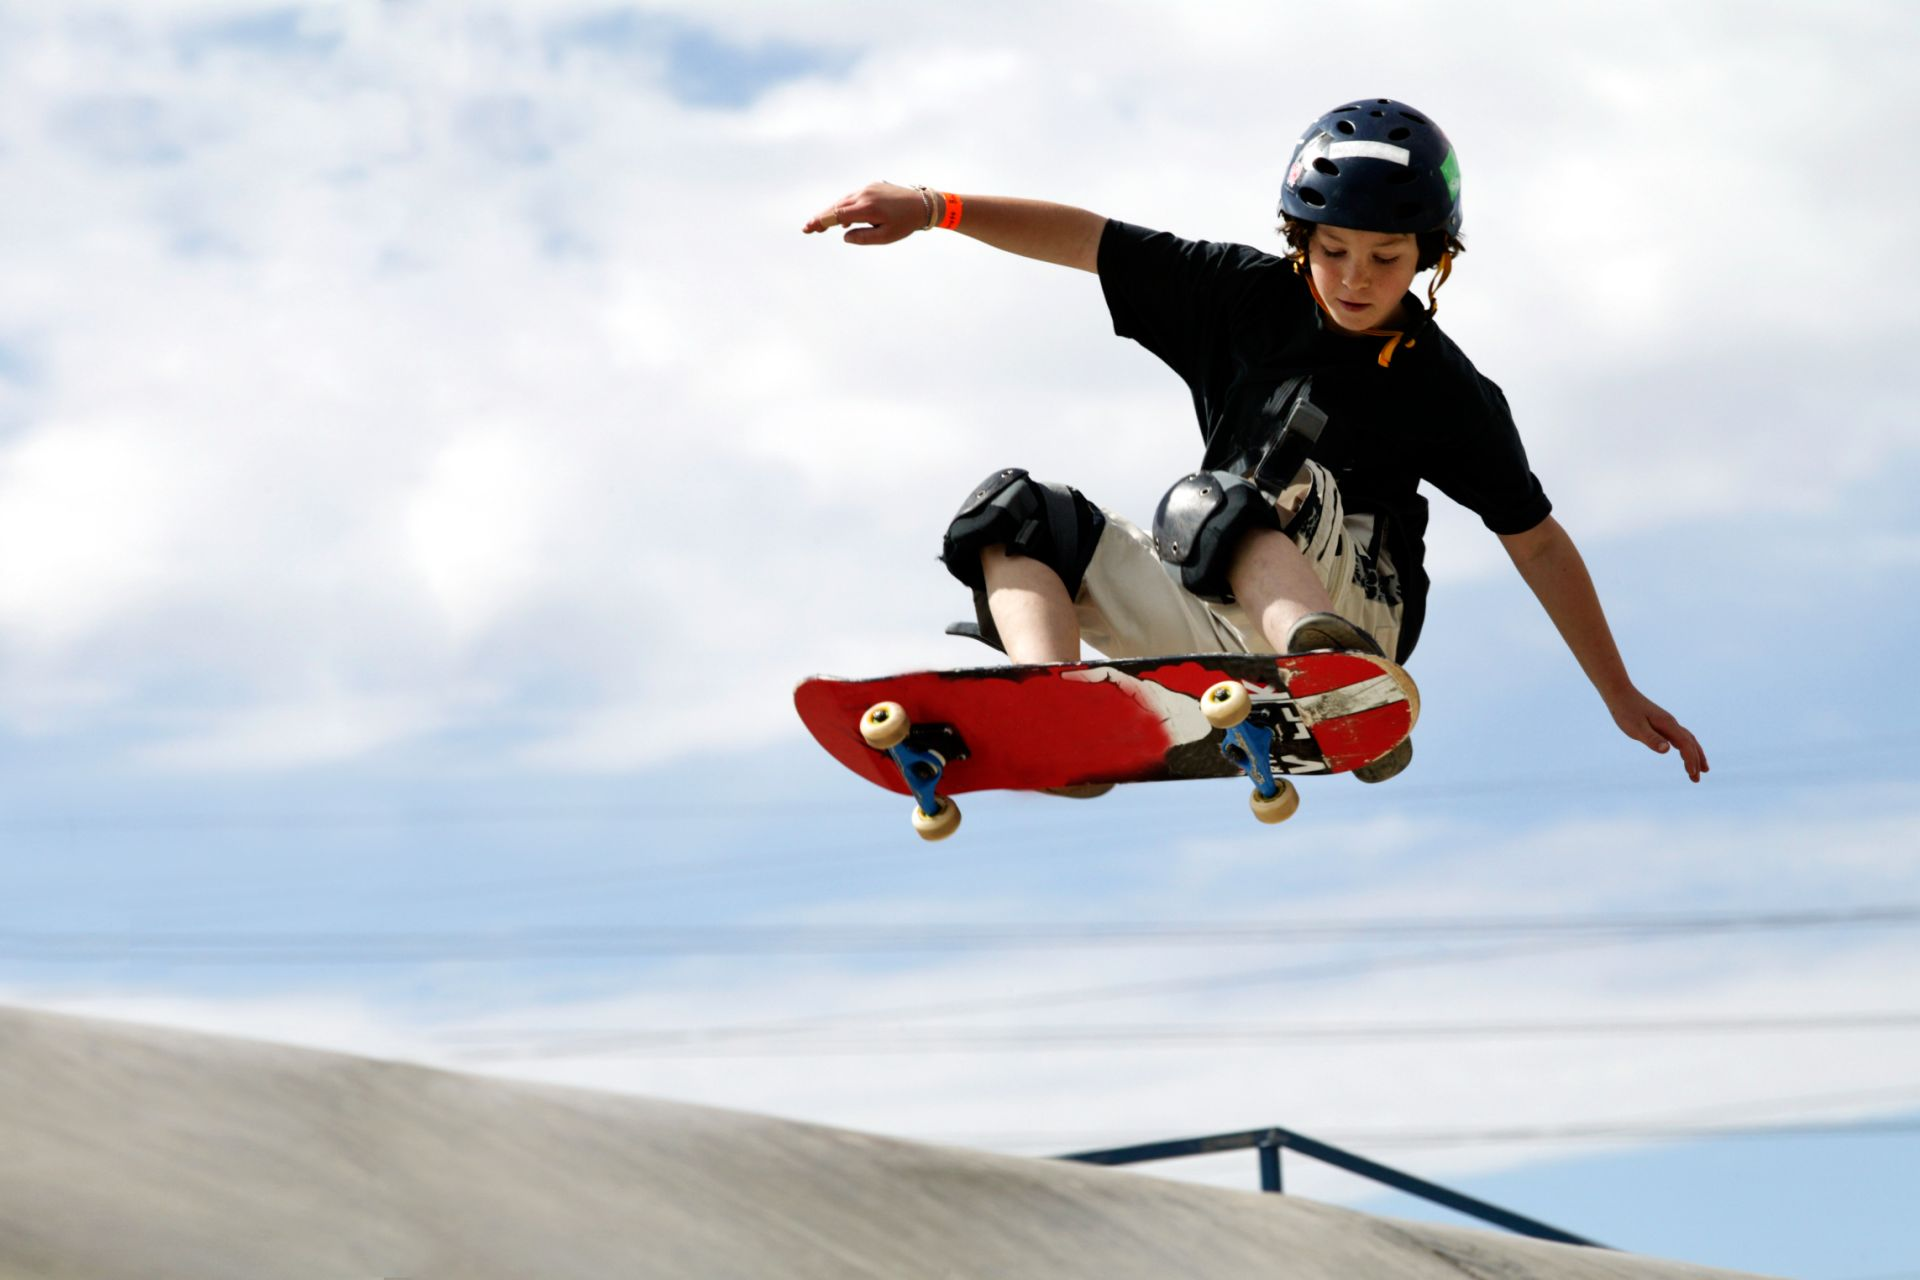

In [24]:
for _ in range(100):
    find_similar_images_neo4j(image1_name="test_image.jpg", top_k=3)
    break

# Sources

https://openai.com/blog/clip/